## This notebook explores the features of signal training data like frequency, amplitude, skewness and etc for clustring algorithm.

In [94]:
# read the data
import pandas as pd
# df_signals = pd.read_csv("signal_dataframe.csv", index_col=None)
df_signals = pd.read_pickle("mms_signals.pkl")
print(df_signals)

      signal_id  dimension                                        time_series
0             0       4481  [4.218142, 4.187014, 4.2369833, 4.2725954, 4.2...
1             1       5120  [-3.3216012, -3.3463109, -3.4138548, -3.420333...
2             2       6013  [-1.2212995, -1.1289556, -1.0622644, -0.953217...
3             3       6275  [-0.22061178, -1.7926348, -2.7961662, -2.10507...
4             4       5628  [-9.16302, -7.6788673, -6.511563, -6.2894163, ...
...         ...        ...                                                ...
1417       1417       2949  [3.9861827, 4.269318, 3.8308966, 3.5838752, 3....
1418       1418       6013  [-19.050776, -18.975794, -18.791145, -18.74585...
1419       1419       5636  [3.4163177, 3.3421097, 3.2759736, 3.216684, 2....
1420       1420       4735  [0.12773134, 0.11027984, 0.10194638, 0.0631797...
1421       1421       3965  [-2.1892447, -2.2684577, -2.3059707, -2.373244...

[1422 rows x 3 columns]


In [95]:
df_signals.dtypes

signal_id       int64
dimension       int64
time_series    object
dtype: object

In [96]:
len(df_signals)

1422

In [97]:
df_signals.loc[1, 'time_series']

array([-3.3216012, -3.3463109, -3.4138548, ..., -4.9514685, -5.1306186,
       -5.314801 ], dtype=float32)

In [100]:
# downsample the signal by 8 to 1024 Samples/seconds
from scipy.signal import resample_poly
signals = []
for i in range(len(df_signals)):
    signal_downsample = resample_poly(df_signals.loc[i, 'time_series'], up=1, down=8)
    signals.append({
    'time_series': signal_downsample})

In [107]:
signals = pd.DataFrame(signals)

In [113]:
signals.loc[0, 'time_series'].shape

(561,)

In [126]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import signal as sp_signal
from scipy.fft import fft, fftfreq

# Feature extraction
def extract_features(signal_data):
    """Extract relevant features from signals"""
    features = []
    dt = 1./1024
    for i in range(len(signal_data)):
        sig = signal_data.loc[i, 'time_series']
        # Time domain features
        amplitude = np.max(np.abs(sig))
        energy = np.sum(sig**2)
        mean_val = np.mean(sig)
        std_val = np.std(sig)
        skewness = np.mean(((sig - mean_val) / std_val)**3)
        kurtosis = np.mean(((sig - mean_val) / std_val)**4)
        
        # Frequency domain features
        fft_vals = np.abs(fft(sig))
        fft_vals = fft_vals[:len(fft_vals)//2]
        freqs = fftfreq(len(sig), dt)[:len(fft_vals)]
        
        dominant_freq = freqs[np.argmax(fft_vals)]
        spectral_centroid = np.sum(freqs * fft_vals) / np.sum(fft_vals)
        spectral_bandwidth = np.sqrt(np.sum(((freqs - spectral_centroid)**2) * fft_vals) / np.sum(fft_vals))
        
        # Peak detection
        peaks, _ = sp_signal.find_peaks(np.abs(sig), height=0.1)
        num_peaks = len(peaks)
        
        # Zero crossings
        zero_crossings = np.sum(np.diff(np.sign(sig)) != 0)
        
        features.append([
            amplitude, energy, mean_val, std_val, skewness, kurtosis,
            dominant_freq, spectral_centroid, spectral_bandwidth,
            num_peaks, zero_crossings
        ])
    return np.array(features)


In [127]:
print("Extracting features...")
features = extract_features(signals)

Extracting features...


In [128]:
features.shape

(1422, 11)

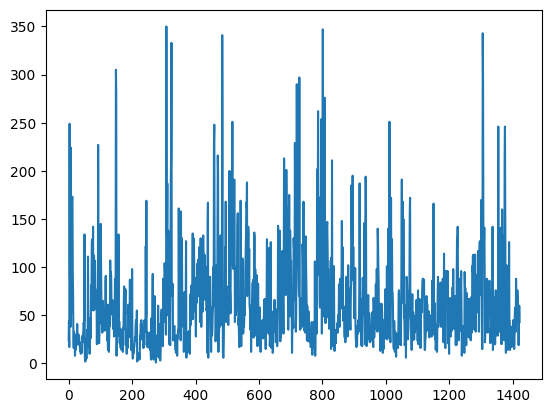

In [142]:
plt.plot(features[:,10])

In [130]:
# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

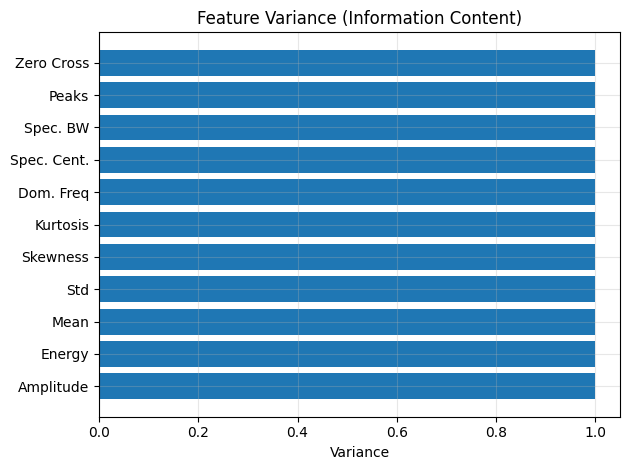

In [131]:
# Feature importance (variance explained)

feature_names = ['Amplitude', 'Energy', 'Mean', 'Std', 'Skewness', 'Kurtosis',
                 'Dom. Freq', 'Spec. Cent.', 'Spec. BW', 'Peaks', 'Zero Cross']
feature_variance = np.var(features_scaled , axis=0)
plt.barh(feature_names, feature_variance)
plt.xlabel('Variance')
plt.title('Feature Variance (Information Content)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tslearn.metrics import dtw
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import squareform
import random

# --------------------------------
# 1. MinMax Scale Each Signal Individually
# --------------------------------
scaled_signals = []
for sig in df_signals["time_series"]:
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(sig.reshape(-1, 1)).flatten()
    scaled_signals.append(scaled)

df_signals["scaled_signal"] = scaled_signals
print("Applied MinMax scaling to all signals.")


# --------------------------------
# 2. Plot 9 Random Signals
# --------------------------------
sample_indices = random.sample(range(len(df_signals)), 9)

plt.figure(figsize=(10, 8))
for i, idx in enumerate(sample_indices):
    plt.subplot(3, 3, i + 1)
    plt.plot(df_signals.loc[idx, "scaled_signal"])
    plt.title(f"ID {idx}")
    plt.tight_layout()
plt.suptitle("9 Random Scaled Signals", fontsize=14, y=1.02)
plt.show()
print("Displayed 9 sample signals.")


# --------------------------------
# 3. DTW Distance Matrix (subset for speed)
# --------------------------------
N = 100  # sample subset to keep computation reasonable
subset = df_signals.sample(N, random_state=42).reset_index(drop=True)

D = np.zeros((N, N))
for i in range(N):
    for j in range(i+1, N):
        dist = dtw(subset.loc[i, "scaled_signal"], subset.loc[j, "scaled_signal"])
        D[i, j] = D[j, i] = dist

print("DTW distance matrix computed for", N, "signals.")


# --------------------------------
# 4. Hierarchical Clustering using DTW distances
# --------------------------------
Z = linkage(squareform(D), method='average')
K = 4
labels = fcluster(Z, K, criterion='maxclust')
subset["cluster"] = labels

print("Assigned clusters:", set(labels))


# --------------------------------
# 5. Visualize cluster members
# --------------------------------
fig, axes = plt.subplots(K, 3, figsize=(10, 7))
for k in range(1, K+1):
    members = subset[subset["cluster"] == k]
    sample_members = members.sample(min(3, len(members)), random_state=42)

    for j, (idx, row) in enumerate(sample_members.iterrows()):
        axes[k-1, j].plot(row["scaled_signal"])
        axes[k-1, j].set_title(f"Cluster {k} (ID {idx})")

plt.tight_layout()
plt.show()
print("Cluster visualization complete.")


# --------------------------------
# 6. Optional: Dendrogram visualization
# --------------------------------
plt.figure(figsize=(12, 4))
dendrogram(Z, color_threshold=0.7 * max(Z[:, 2]))
plt.title("DTW Hierarchical Clustering Dendrogram")
plt.xlabel("Signal Index")
plt.ylabel("DTW Distance")
plt.show()
print("Dendrogram plotted.")


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans
from tslearn.clustering import silhouette_score

# -------------------------------
# Convert dataframe → numpy list of time series
# -------------------------------
signals_list = df_signals['time_series'].tolist()

# -------------------------------
# Normalize each signal individually
# -------------------------------
scaler = TimeSeriesScalerMeanVariance()
X_scaled = scaler.fit_transform(signals_list)

# Convert into 3D array expected by tslearn: (n_samples, timesteps, 1)
# tslearn supports variable lengths implicitly
X = np.array([s.reshape(-1,1) for s in X_scaled], dtype=object)

#
# -------------------------------
# DTW KMeans Clustering
# -------------------------------
n_clusters = 4  # Try 4 based on FREQ groups; can tune later

model = TimeSeriesKMeans(
    n_clusters=n_clusters,
    metric="dtw",
    max_iter=50,
    random_state=42,
    n_jobs=-1
)

labels = model.fit_predict(X_scaled)
centroids = model.cluster_centers_

# -------------------------------
# Add labels to dataframe
# -------------------------------
df_signals['cluster'] = labels

# -------------------------------
# Silhouette Score (DTW distance)
# -------------------------------
sil = silhouette_score(X_scaled, labels, metric="dtw")
print(f"\nSilhouette Score: {sil:.3f}")

# -------------------------------
# Plot clusters with centroids
# -------------------------------
plt.figure(figsize=(15,10))
for c in range(n_clusters):
    plt.subplot(2, 2, c+1)
    for i, x in enumerate(X_scaled[labels == c]):
        plt.plot(x.ravel(), alpha=0.20)
    plt.plot(centroids[c].ravel(), linewidth=3, label=f"Centroid {c}")
    plt.title(f"Cluster {c}")
    plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import random
# --------------------------------
# 2. Plot Random Signals
# --------------------------------
sample_indices = random.sample(range(len(df_signals)), 100)

plt.figure(figsize=(10, 20))
for i, idx in enumerate(sample_indices):
    plt.subplot(20, 5, i + 1)
    plt.plot(df_signals.loc[idx, "time_series"])
    plt.title(f"ID {idx}")
    plt.tight_layout()
plt.suptitle("Random Scaled Signals", fontsize=14, y=1.02)
plt.show()
print("Displayed sample signals.")
